# Assess Group-Contribution Models
[Group Contribution](https://en.wikipedia.org/wiki/Group-contribution_method) models express molecular properties as a sum over all non-hydrogen atoms in a molecule with each atom having a contribution amount based on its functional group. 
Here, we explore the accuracy for such methods.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from keras.models import load_model
from rdkit import Chem
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

## Load in Benchmark Data
We are going to use the standard set

In [2]:
train_data, test_data = load_benchmark_data()

## Get MPNN Results
Get the best MPNN for water that did not use DFT charges

In [3]:
mpnn_data = pd.read_json(os.path.join('..', 'mpnn', 'mpnn-results.json'))
mpnn_data = mpnn_data[~ mpnn_data.network.str.contains('dielectric-constant-charges')]

In [4]:
chosen_model = mpnn_data.query('nodes==128 and batch_size==16384 and ("constant-charges" not in network)').sort_values('mae_water', ascending=True).head(1).iloc[0]

In [5]:
print(f'Our best-performing network is: {chosen_model["network"]}')

Our best-performing network is: single-task


In [6]:
set_custom_objects()

In [7]:
model = load_model(os.path.join('..', 'mpnn', chosen_model['path'], 'best_model.h5'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [8]:
with open(os.path.join('..', 'mpnn', 'networks', chosen_model['network'], 'converter.pkl'), 'rb') as fp:
    conv = pkl.load(fp)

In [9]:
%%time
test_data['mpnn_pred'] = run_model(model, conv, test_data['smiles_0'], n_jobs=1)

CPU times: user 4min 16s, sys: 32.8 s, total: 4min 49s
Wall time: 15.2 s


In [10]:
mpnn_mae = metrics.mean_absolute_error(test_data['sol_water'], test_data['mpnn_pred'])
print(f'MAE of MPNN:{mpnn_mae: .3f} kcal/mol')

MAE of MPNN: 0.431 kcal/mol


## Identify All Possible Groups
We are going to define a group based on the compositions of atoms it is connected to.
For example, this will distinguish primary and secondary amine groups.

In [11]:
def get_groups(smiles: str) -> [str]:
    """Get the group identities of each non-hydrogen atom in a molecule
    
    We represent group identities as a SMARTS string
    
    Args:
        smiles (str): SMILES string of a molecule
    Returns:
        ([str]) Identities of each atom
    """
    
    # Parse the molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []  # Fails to parse
    
    # Loop over non-H atoms
    output = []
    for a in mol.GetAtoms():
        # Get my SMARTS type
        my_type = f'[{a.GetSmarts()}D{a.GetDegree()}]'
        
        # Loop over bonds
        bonds = []
        for b in a.GetBonds():
            bt = str(b.GetBondType())
            other_atom = b.GetOtherAtom(a)
            other_type = f'[{other_atom.GetSmarts()}D{other_atom.GetDegree()}]'
            if bt == "SINGLE":
                bonds.append(other_type)
            elif bt == "DOUBLE":
                bonds.append(f'={other_type}')
            elif bt == "TRIPLE":
                bonds.append(f'#{other_type}')
            elif bt == "AROMATIC":
                bonds.append(f':{other_type}')
            else:
                raise ValueError(f'Unsupported bond type: {bt}')
        
        # Compile them into a SMARTS
        if len(bonds) > 0:
            bonds = sorted(bonds)
            my_type += ''.join(f'({x})' for x in bonds[:-1])
            my_type += bonds[-1]
        output.append(my_type)
    return output

Run the function over all molecules in QM9

In [12]:
%%time
all_types = set()
train_data['smiles_0'].apply(get_groups).apply(all_types.update)
test_data['smiles_0'].apply(get_groups).apply(all_types.update)
print(f'Found {len(all_types)} unique types')

Found 1227 unique types
CPU times: user 28.2 s, sys: 85.7 ms, total: 28.3 s
Wall time: 28.3 s


Assign them indices. We hold it in a dictionary for faster lookup

In [13]:
type_lookup = dict([(x, i) for i, x in enumerate(sorted(all_types))])

Compute the feature matrices for the train and test data

In [14]:
def compute_features(smiles):
    """Compute the feature matrices for a certain SMILES string"""
    
    # Get the groups
    groups = get_groups(smiles)
    
    # Get their indices
    output = np.zeros((len(all_types)), dtype=np.int)
    for g in groups:
        output[type_lookup[g]] += 1
    return output

In [15]:
train_X = np.vstack(train_data['smiles_0'].apply(compute_features))

In [16]:
test_X = np.vstack(test_data['smiles_0'].apply(compute_features))

## Make Linear Regression Models
We are going to model the solvation energy in water and show the MAE as a function of training set size

In [17]:
model = LassoCV(cv=10)

In [18]:
results = []
for ts in tqdm([10**x for x in np.arange(1, 5.1, step=0.25)] + [len(train_data)]):
    # Create a subset
    inds = np.random.choice(len(train_data), size=int(ts), replace=False)
    subset_X = train_X[inds, :]
    subset_y = train_data['sol_water'].iloc[inds]
    
    # Train the model and evaluate on test set
    model.fit(subset_X, subset_y)
    pred_y = model.predict(test_X)
    results.append({
        'train_size': int(ts),
        'mae': metrics.mean_absolute_error(pred_y, test_data['sol_water'])
    })

 72%|███████▏  | 13/18 [01:13<01:08, 13.69s/it]/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
 83%|████████▎ | 15/18 [03:24<02:01, 40.66s/it]/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with 

In [19]:
results = pd.DataFrame(results)

Print results for the full dataset size

In [20]:
print(f'{len(np.nonzero(model.coef_)[0])} nonzero coefficients')

420 nonzero coefficients


In [21]:
results.iloc[-1]

mae                1.013963
train_size    117232.000000
Name: 17, dtype: float64

Compare to the MPNN

In [22]:
print(f'MPNN out performs LASSO by a factor of{results["mae"].iloc[-1] / mpnn_mae: .1f}x')

MPNN out performs LASSO by a factor of 2.4x


Plot the linear regression for the whole dataset vs the MPNN, and show the learning curve summary

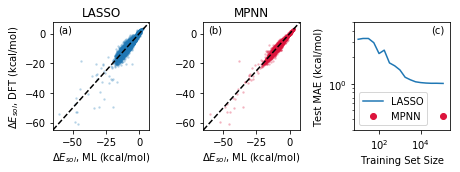

In [23]:
fig = plt.figure(figsize=(6.5, 2.5))

scatter_settings = dict(s=2.5, alpha=0.2)

# Make the scatter plots
lr_ax = fig.add_subplot(131)
lr_ax.scatter(pred_y, test_data['sol_water'], **scatter_settings)
lr_ax.set_xlim(-65, 7.5)
lr_ax.set_ylim(lr_ax.get_xlim())
lr_ax.plot(lr_ax.get_xlim(), lr_ax.get_xlim(), 'k--')
lr_ax.set_xlabel('$\Delta E_{sol}$, ML (kcal/mol)')
lr_ax.set_ylabel('$\Delta E_{sol}$, DFT (kcal/mol)')
lr_ax.set_title('LASSO', fontsize=12)

mpnn_ax = fig.add_subplot(132, sharex=lr_ax, )
mpnn_ax.scatter(test_data['mpnn_pred'], test_data['sol_water'], c='crimson', **scatter_settings)
mpnn_ax.set_xlabel('$\Delta E_{sol}$, ML (kcal/mol)')
mpnn_ax.set_ylim(lr_ax.get_xlim())
mpnn_ax.plot(lr_ax.get_xlim(), lr_ax.get_xlim(), 'k--')
mpnn_ax.set_title('MPNN')

for a, l in zip([lr_ax, mpnn_ax], ['a', 'b']):
    a.text(0.05, 0.9, f'({l})', transform=a.transAxes)

# Make the training curvea
ax = fig.add_subplot(133)
ax.loglog(results['train_size'], results['mae'], label='LASSO')
ax.scatter([chosen_model['entries']], [chosen_model['mae_water']], color='crimson', label='MPNN')
ax.text(0.8, 0.9, f'(c)', transform=ax.transAxes)

ax.set_ylim(0.3, 5)
fig.tight_layout(h_pad=0)
ax.legend()
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Test MAE (kcal/mol)')

fig.tight_layout()
fig.savefig(os.path.join('figures', 'lr-comparison.png'), dpi=320)
fig.savefig(os.path.join('figures', 'lr-comparison.eps'))

Save the coefficients from the model

In [24]:
lasso_coeff = dict((json.dumps(x), {'coef': model.coef_[i], 'count': int(train_X[:, i].sum())}) for x, i in type_lookup.items())

In [25]:
with open('lasso_coef.json', 'w') as fp:
    json.dump(lasso_coeff, fp)